In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import re
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("/Users/ayaskantsamal/Documents/EXCELR/assignments/CocaCola_Sales_Rawdata.xlsx",sheet_name='Sheet1')
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
df=df.set_index('Quarter')
df.head()

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996


In [4]:
df.index = df.index.str.replace(r'(Q\d)_(\d+)', r'\2-\1')
df.head()

,Sales
Quarter,
86-Q1,1734.827000
86-Q2,2244.960999
86-Q3,2533.804993
86-Q4,2154.962997
87-Q1,1547.818996


In [5]:
df.index = pd.PeriodIndex(df.index, freq='Q').to_timestamp()
df.head()

,Sales
Quarter,
2086-01-01,1734.827000
2086-04-01,2244.960999
2086-07-01,2533.804993
2086-10-01,2154.962997
2087-01-01,1547.818996


## Time Series Analysis

<AxesSubplot:ylabel='Count'>

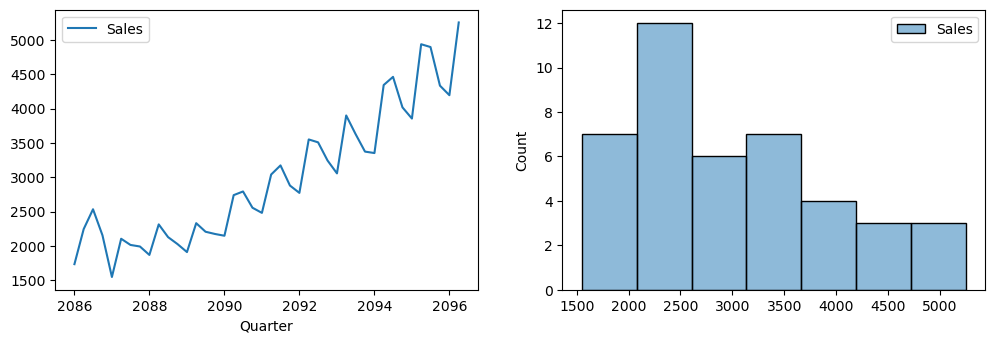

In [6]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.lineplot(df)
plt.subplot(2,2,2)
sns.histplot(df)


## Time series decomposition

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose


<Figure size 1200x800 with 0 Axes>

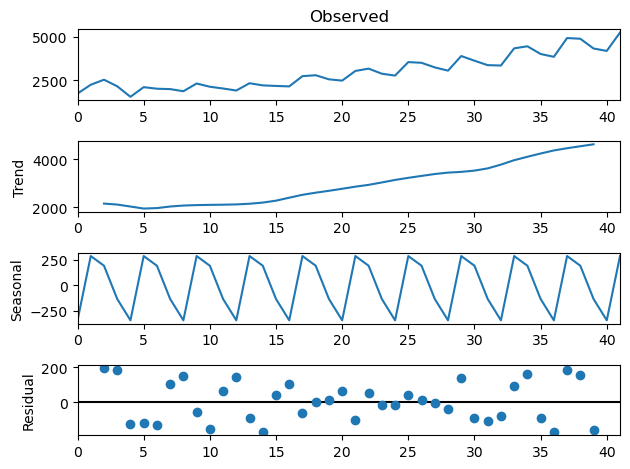

In [8]:
#graphs for quarterly data with additive decompose 

plt.figure(figsize=(12,8))
ts_decomp= seasonal_decompose((df.values),model='additive',period = 4)

ts_plot = ts_decomp.plot()

<Figure size 1200x800 with 0 Axes>

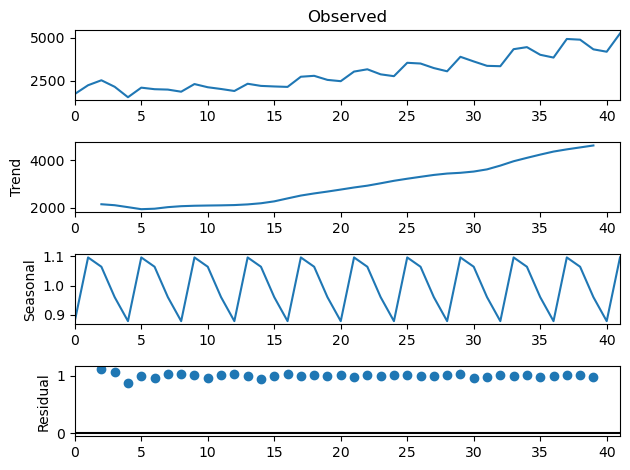

In [9]:
# Multiplicative seasonal decompose
plt.figure(figsize=(12,8))
ts_decomp_mul= seasonal_decompose((df.values),model='multiplicative',period = 4)

ts_plot_mul = ts_decomp_mul.plot()

## Forecasting models building

In [10]:
df.shape

(42, 1)

In [11]:
## Splitting into train and test data
X_train=df[0:30]
X_test=df[30:]

In [12]:
X_train.shape,X_test.shape



((30, 1), (12, 1))

## 1. Simple Moving Average

In [13]:
df_moving=df.copy()

In [14]:
train_len=30

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
roll_val=[]
rmse_val=[]

for i in range(4,30,4):
    df_moving['ma_forecast'] = df_moving['Sales'].rolling(i).mean()
    df_moving['ma_forecast'][train_len:] = df_moving['ma_forecast'][train_len-1]
    rmse_ma = mean_squared_error(X_test['Sales'],df_moving['ma_forecast'][train_len:],squared=False).round(2)
    roll_val.append(i)
    rmse_val.append(rmse_ma)


In [17]:
df1=pd.DataFrame({'Rolling window':roll_val,'rmse':rmse_val})
df1

,Rolling window,rmse
0,4,986.03
1,8,1124.51
2,12,1282.40
3,16,1454.49
4,20,1600.25
5,24,1706.78
6,28,1778.29


In [18]:
df_moving['ma_forecast'] = df_moving['Sales'].rolling(4).mean()
df_moving['ma_forecast'][train_len:] = df_moving['ma_forecast'][train_len-1]
rmse_ma = mean_squared_error(X_test['Sales'],df_moving['ma_forecast'][train_len:],squared=False).round(2)
rmse_ma

986.03

## 2. Simple Exponential Smoothing

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [20]:
ses_model = SimpleExpSmoothing(X_train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = X_test.index[0],end = X_test.index[-1])

In [21]:
rmse_ses = mean_squared_error(X_test['Sales'],pred_ses,squared=False).round(2)
rmse_ses

1153.7

## 3. Holt's Method

In [22]:
from statsmodels.tsa.holtwinters import Holt

In [23]:
holt_model = Holt(X_train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_holt = holt_model.predict(start = X_test.index[0],end = X_test.index[-1])

In [24]:
rmse_holt = mean_squared_error(X_test['Sales'],pred_holt,squared=False).round(2)
rmse_holt

559.52

## 4. Holt's Exponential Smoothing

### a. Additive Method

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [26]:
hes_add_add = ExponentialSmoothing(X_train['Sales'],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hes_add_add = hes_add_add.predict(start = X_test.index[0],end = X_test.index[-1])

In [27]:
rmse_hes_add_add = mean_squared_error(X_test['Sales'],pred_hes_add_add,squared=False).round(2)
rmse_hes_add_add

309.28

### b. Multiplicative Method

In [28]:
hes_mul_add = ExponentialSmoothing(X_train['Sales'],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hes_mul_add = hes_mul_add.predict(start = X_test.index[0],end = X_test.index[-1])

In [29]:
rmse_hes_mul_add = mean_squared_error(X_test['Sales'],pred_hes_mul_add,squared=False).round(2)
rmse_hes_mul_add

349.13

## 5. ARIMA model

### ACF Plot

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

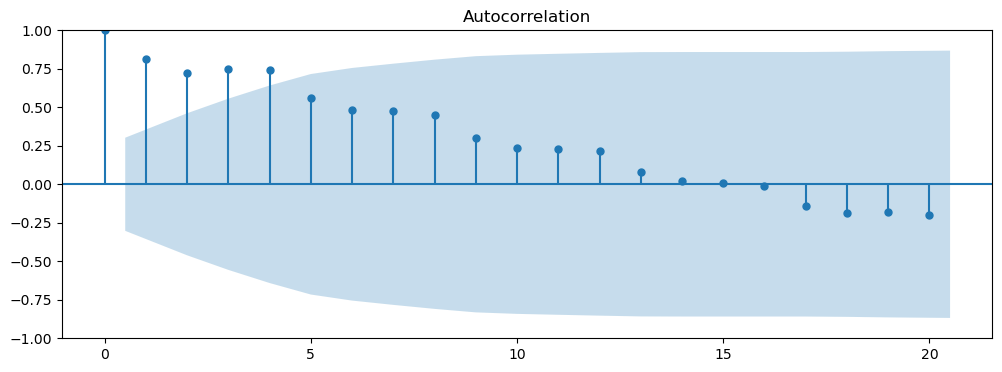

In [31]:
# Show autocorrelation upto lag 20
plt.figure(figsize=(12,4))
acf_plot = plot_acf( df['Sales'],ax=plt.gca(),lags=20)
plt.show()

### PCF Plot

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf

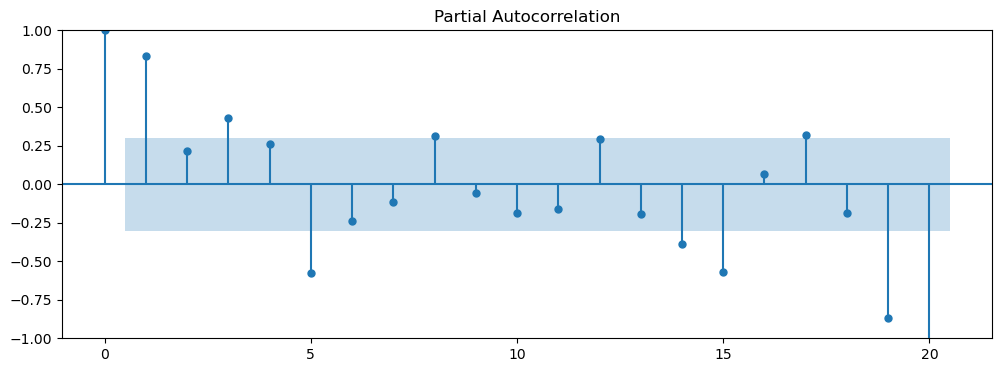

In [33]:
plt.figure(figsize=(12,4))
pacf_plot = plot_pacf( df['Sales'],ax=plt.gca(),lags=20)
plt.show()

In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
arima = ARIMA(X_train['Sales'], order=(1,1,1)).fit()
pred_arima= arima.predict(start = X_test.index[0],end = X_test.index[-1])

In [36]:
rmse_arima = mean_squared_error(X_test['Sales'],pred_arima,squared=False).round(2)
rmse_arima

896.39

## Choosing the best model

In [37]:
Final=['simple_moving_average','simple_expo_smoothing','Holt','Holt_additive','Holt_multiplicative','ARIMA']
rmse=[rmse_ma,rmse_ses,rmse_holt,rmse_hes_add_add,rmse_hes_mul_add,rmse_arima]
model={'Models':Final,'Rmse':rmse}
df_model=pd.DataFrame(model)
df_model.sort_values(by='Rmse')

,Models,Rmse
3,Holt_additive,309.28
4,Holt_multiplicative,349.13
2,Holt,559.52
5,ARIMA,896.39
0,simple_moving_average,986.03
1,simple_expo_smoothing,1153.70


Holt's model is the best one as it has the lowest rmse of all models.